In [1]:
# Importa los modulos Python necesarios

# Configura GPU, da opcion de usar CPU
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Reemplaza por "" para usar CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Importa Sionna
# Si ejecuta localmente, no olvide instalar Sionna con "pip install sionna"
# Si ejecuta en Google Colab se instala automaticamente, ejecutar celda dos veces
try:
    import sionna
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Instala Sionna en Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Importa TensorFlow
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

# Importa otros modulos necesarios
import numpy as np
import pandas as pd
from datetime import datetime

# Configura Matplotlib para graficos dentro del cuaderno
%matplotlib inline
import matplotlib.pyplot as plt

2026-01-22 21:39:31.002820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769135971.031859   23222 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769135971.040930   23222 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769135971.077925   23222 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769135971.077967   23222 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769135971.077969   23222 computation_placer.cc:177] computation placer alr

In [7]:
# Parametros generales de la simulacion

# Parametros basicos
sionna.phy.config.seed = 0 # semilla aleatoria
N = 128 # longitud del código (potencia de 2)
K = 64 # número de bits de información (0 < K < N)
bitsxsimb = 1 # bits por símbolo (por defecto: BPSK)
if bitsxsimb == 1:
    modulacion = "pam" # +1+0j y -1+0j para BPSK
else:
    modulacion = "qam" # QAM para más bits por símbolo

# Parametros del canal y ecualizador
canal = "rice" # posibles valores: "awgn", "rayleigh", "rice", "lognormal", "suzuki"
ecualizador = "mmse" # posibles valores: "mmse", "zf", "no_eq"  
bloq_coher = 4 # numero de simbolos por bloque de coherencia (bloq_coher < N)
k_factor_db = 3.0 # canal Rice: factor K en dB (ratio de potencias LOS/NLOS, valores tipicos 3 a 12 dB)
sigma_db = 6.0 # canal Log-normal: desviacion estandar en dB (valores tipicos 6 a 12 dB)
LLR_clip = 500 # valor de recorte para LLRs. Evita inestabilidades numéricas

# Parametros del codificador/decodificador
# DATO: Cada bit-canal se simula lote_mc * num_iter veces
list_scl = 8 # tamaño de lista para decodificador SCL
lote_mc = 2000 # numero de muestras a procesar en paralelo (emplea VRAM)
num_iter = 1000 # numero de muestras a procesar en secuencia (emplea tiempo)
snr_simulacion = 12.0 # valor sugerido 6 dB para AWGN, 12 dB para otros canales

# Clases Sionna comunes
datos = sionna.phy.mapping.BinarySource() # generador de datos aleatorios
constelacion = sionna.phy.mapping.Constellation(modulacion, bitsxsimb) # define la constelacion (BPSK o QAM)
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion) # mapeador bits a simbolos (binario a complejo)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion) # inverso del mapeador
interleaver = sionna.phy.fec.interleaving.RandomInterleaver(seed=0, axis=-1) # interleaver a lo largo de N
deinterleaver = sionna.phy.fec.interleaving.Deinterleaver(interleaver) # inverso del interleaver

# Parametros de ploteo
EBNO_DB_MIN = 0 # Eb/N0 mínimo en dB
EBNO_DB_MAX = 20 # Eb/N0 máximo en dB
EBNO_RANGO = EBNO_DB_MAX - EBNO_DB_MIN + 1 # rango de Eb/N0
lote_berplot = 400 # tamaño de lote para ploteo de curvas

In [8]:
# Modelos de canal

# Canal AWGN (base teorica)
@tf.function(jit_compile=True)
def canalAWGN(ebno_db, bitsxsimb, coderate, x):
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    h = 1.0 + 0.0j # canal sin desvanecimiento
    y = x + awgn
    return y, h, no

# Canal Rayleigh (desvanecimiento por multitrayecto)
@tf.function(jit_compile=True)
def canalRayleigh(bloq_coher, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch de la señal
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h necesarias
    # ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # h se mantiene constante en la dimension de N
    h_real = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h_imag = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h = tf.repeat(tf.complex(h_real, h_imag), repeats=bloq_coher, axis=1) # h fijo por bloque de coherencia
    h = h[:, :N] # recorta a la longitud de bloque N
    y = h * x + awgn
    return y, h, no

# Canal Rice (existe LOS dominante y desvanecimiento por multitrayecto)
@tf.function(jit_compile=True)
def canalRice(bloq_coher, k_factor_db, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h necesarias
    # ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # calcula el valor lineal del factor K (ratio de potencias LOS/NLOS)
    k_factor_lin = tf.pow(10.0, tf.cast(k_factor_db, tf.float32) / 10.0)
    # valor de la componente NLOS
    h_nlos_real = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h_nlos_imag = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h_nlos = tf.complex(h_nlos_real, h_nlos_imag)
    # fasor de LOS (amplitud constante, fase aleatoria)
    phi = sionna.phy.config.tf_rng.uniform([batch_size, repeticiones], minval=0.0, maxval=tf.constant(2.0*np.pi, tf.float32))
    h_los = tf.complex(tf.cos(phi), tf.sin(phi))
    # combina componentes LOS y NLOS
    a = tf.sqrt(k_factor_lin/(k_factor_lin + 1.0)) # amplitud LOS
    b = tf.sqrt(1.0/(k_factor_lin + 1.0))     # amplitud NLOS
    h_bloque = tf.cast(a, tf.complex64)*tf.cast(h_los, tf.complex64) + tf.cast(b, tf.complex64)*tf.cast(h_nlos, tf.complex64)
    # repite h por bloque de coherencia
    h = tf.repeat(h_bloque, repeats=bloq_coher, axis=1)
    h = h[:, :N] # recorta a la longitud N
    y = h * x + awgn
    return y, h, no

# Canal Log-Normal (desvanecimiento profundo)
@tf.function(jit_compile=True)
def canalLognormal(bloq_coher, sigma_db, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h necesarias
    # ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # calcula el valor lineal de la desviacion estandar (dB) y calcula media (lineal) para potencia normalizada
    sigma_ln = tf.cast(tf.math.log(10.0) / 20.0 * sigma_db, tf.float32)
    mu_ln = -tf.square(sigma_ln) # para E[z^2]=1 -> media = -sigma_ln^2
    # calcula canal Lognormal
    z = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], mean=mu_ln, stddev=sigma_ln, dtype=tf.float32)
    a = tf.exp(z) # amplitud log-normal
    a = tf.repeat(a, repeats=bloq_coher, axis=1) # fijo por bloque de coherencia
    a = a[:, :N] # recorta a la longitud de bloque N
    h = tf.complex(a, tf.zeros_like(a)) # canal Lognormal
    y = h * x + awgn
    return y, h, no

# Canal Suzuki (Rayleigh*Lognormal)
@tf.function(jit_compile=True)
def canalRayleighLognormal(bloq_coher, sigma_db, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h necesarias
    # ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # factor Rayleigh
    g_real = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    g_imag = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    g = tf.complex(g_real, g_imag)
    # factor Lognormal
    sigma_ln = tf.cast(tf.math.log(10.0) / 20.0 * sigma_db, tf.float32)
    mu_ln = -tf.square(sigma_ln) # para E[h^2]=1 -> media = -sigma_ln^2
    z = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], mean=mu_ln, stddev=sigma_ln, dtype=tf.float32)
    a = tf.exp(z) # amplitud log-normal
    a_c = tf.complex(a, tf.zeros_like(a)) # canal Lognormal
    # canal compuesto Rayleigh*Lognormal
    h_comp = g * a_c
    h = tf.repeat(h_comp, repeats=bloq_coher, axis=1) # h fijo por bloque de coherencia
    h = h[:, :N] # recorta a la longitud de bloque N
    y = h * x + awgn
    return y, h, no

In [9]:
# Ecualizadores

# Sin ecualizador
@tf.function(jit_compile=True)
def sin_ecualizar(y, h, no):
    return y, no

# Ecualizador ZF (Zero Forcing)
@tf.function(jit_compile=True)
def zf(y, h, no, eps=1e-12):
    h2 = tf.maximum(tf.math.square(tf.abs(h)), eps)
    x_hat = y * tf.math.conj(h) / tf.cast(h2, tf.complex64)
    no_eff = no / tf.maximum(h2, eps)
    return x_hat, no_eff

# Ecualizador MMSE (Minimum Mean Square Error)
@tf.function(jit_compile=True)
def mmse(y, h, no, eps=1e-12):
    g = tf.math.conj(h) / tf.cast(tf.math.square(tf.abs(h)) + no, tf.complex64)
    d = g * h
    d_abs = tf.maximum(tf.abs(d), eps)
    x_hat = g * y / tf.cast(d_abs, tf.complex64)
    no_eff = no / tf.maximum(tf.math.square(tf.abs(h)), eps)
    return x_hat, no_eff

In [10]:
# Define el sistema de telecomunicaciones a simular, sin código de canal

class SinCodigo(sionna.phy.Block):
    def __init__(self, canal, ecualizador, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.K = K
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = datos([batch_size, self.K])
        b_int = interleaver(b)
        x = mapeador(b_int)
        
        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        else:
            raise Exception("Debe seleccionar un canal valido")

        # Seleccion de ecualizador
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("Debe seleccionar un ecualizador valido")
        
        # Bloques de recepcion
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)

        return b, llr

In [11]:
# Se crea la instancia de clase sin codigo de canal con los parametros generales

sin_codigo = SinCodigo(canal, ecualizador, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

I0000 00:00:1769136022.504606   23222 service.cc:152] XLA service 0x26824160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769136022.504654   23222 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 3500 Ada Generation Laptop GPU, Compute Capability 8.9
I0000 00:00:1769136022.531662   23222 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1769136023.462124   23222 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.2305e-01 | 1.0000e+00 |        3150 |       25600 |          400 |         400 |         2.5 |reached target block errors
      1.0 | 1.0227e-01 | 9.9500e-01 |        2618 |       25600 |          398 |         400 |         0.0 |reached target block errors
      2.0 | 8.3867e-02 | 9.8750e-01 |        2147 |       25600 |          395 |         400 |         0.0 |reached target block errors
      3.0 | 6.5234e-02 | 9.8750e-01 |        1670 |       25600 |          395 |         400 |         0.0 |reached target block errors
      4.0 | 5.2383e-02 | 9.3500e-01 |        1341 |       25600 |          374 |         400 |         0.0 |reached target block errors
      5.0 | 4.4141e-02 | 9.2750e-01 |        1130 |       25600 |

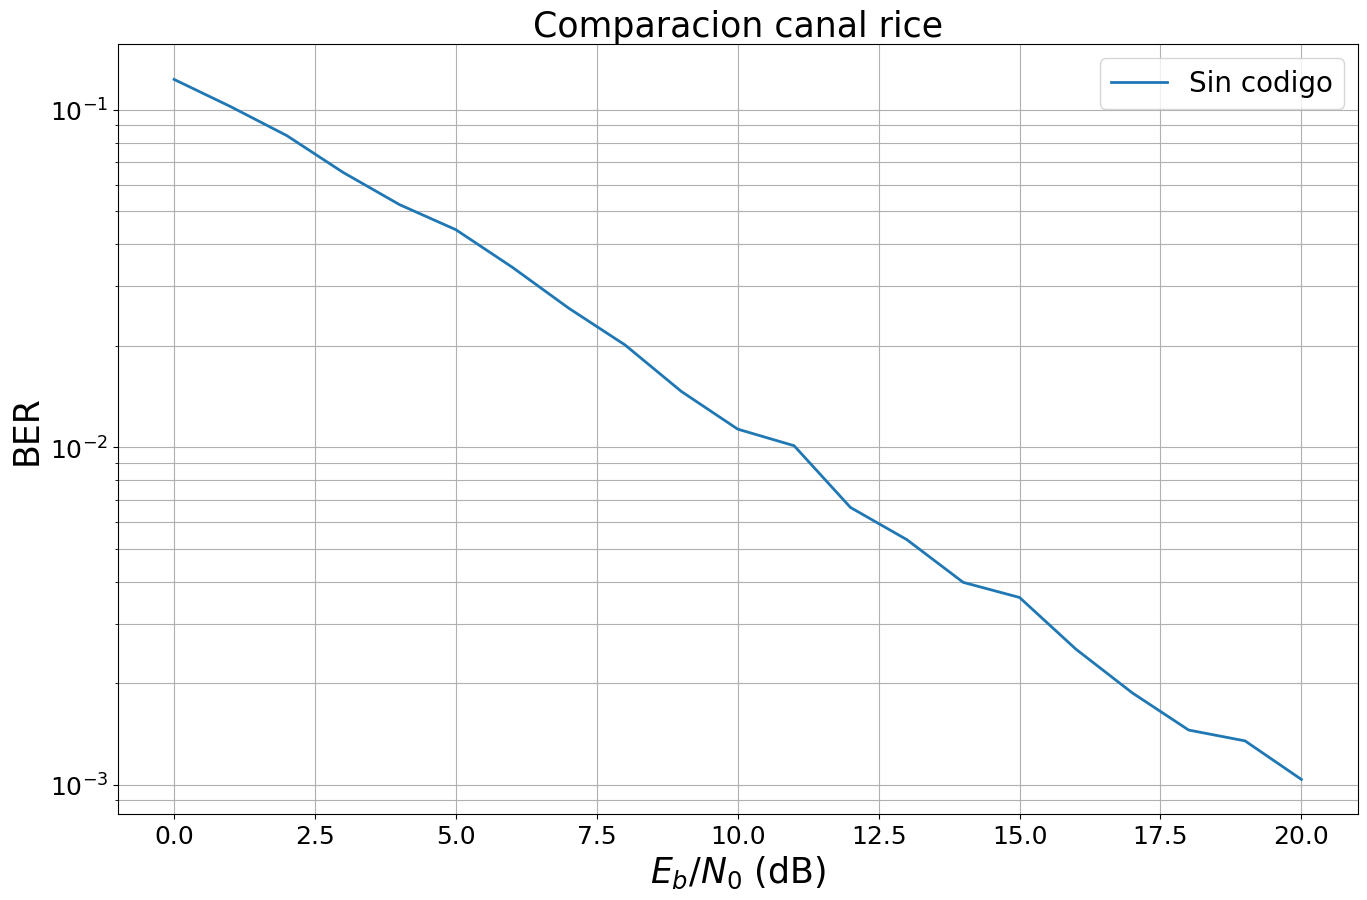

In [12]:
# Simulación y ploteo de BER sin codigo de canal

ber_plots = sionna.phy.utils.PlotBER(f"Comparacion canal {canal}")
ber_plots.simulate(sin_codigo,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=100,
                   legend="Sin codigo",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True);

In [13]:
# Generador Monte Carlo de bits congelados con XLA acceleration

# Función compilada XLA para simulacion de batch_size
@tf.function(jit_compile=True)
def simulacion_batch_size(canal, snr_simulacion, bitsxsimb, batch_size, N, codificador, decodificador):
    # Bloques de transmision
    bits = datos([batch_size, 1]) # solo 1 bit de datos por bit-canal
    bits_codif = codificador(bits) # codifica a N bits
    bits_int = interleaver(bits_codif)
    x = mapeador(bits_int)

    # Seleccion de canal (solo 1 bit de datos por bit-canal)
    if canal == "awgn":
        y, h, no = canalAWGN(snr_simulacion, bitsxsimb, coderate=1.0/N, x=x)
    elif canal == "rayleigh":
        y, h, no = canalRayleigh(bloq_coher, snr_simulacion, bitsxsimb, coderate=1.0/N, x=x)
    elif canal == "rice":
        y, h, no = canalRice(bloq_coher, k_factor_db, snr_simulacion, bitsxsimb, coderate=1.0/N, x=x)
    elif canal == "lognormal":
        y, h, no = canalLognormal(bloq_coher, sigma_db, snr_simulacion, bitsxsimb, coderate=1.0/N, x=x)
    elif canal == "suzuki":
        y, h, no = canalRayleighLognormal(bloq_coher, sigma_db, snr_simulacion, bitsxsimb, coderate=1.0/N, x=x)
    else:
        raise Exception("Debe seleccionar un canal valido")

    # Seleccion de ecualizador
    if ecualizador == "no_eq":
        x_hat, no_eff = sin_ecualizar(y, h, no)
    elif ecualizador == "zf":
        x_hat, no_eff = zf(y, h, no)
    elif ecualizador == "mmse":
        x_hat, no_eff = mmse(y, h, no)
    else:
        raise Exception("Debe seleccionar un ecualizador valido")
    
    # Bloques de recepcion
    llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
    llr = deinterleaver(llr_prev)
    bits_decodif = decodificador(llr)

    # Cálculo de errores
    err = tf.math.count_nonzero(tf.not_equal(bits, bits_decodif), dtype=tf.int32)
    
    return tf.cast(err, tf.int64), tf.constant(batch_size, dtype=tf.int64)

# Estimador de BER por bit-canal usando Monte Carlo
BER_bits = np.zeros(N)
for i in range(N):
    print(f"Procesando bit-canal {i+1}/{N}", end="", flush=True)

    # Se setean los bits congelados y reinicia conteo errores
    bits_congelados = np.array([j for j in range(N) if j != i]) # se analiza cada bit-canal
    codificador = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
    decodificador = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=list_scl)
    errores_totales = 0
    bits_totales = 0

    # Se itera num_iter veces para acumular errores
    for b in range(num_iter):
        err, total = simulacion_batch_size(canal, snr_simulacion, bitsxsimb, lote_mc, N, codificador, decodificador)
        errores_totales += int(err.numpy()) # acumula errores
        bits_totales += int(total.numpy())

    print()
    BER_bits[i] = errores_totales / bits_totales # calcula BER para el bit-canal i

# Selecciona los bits congelados como los N-K bits con mayor BER
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

Procesando bit-canal 1/128
Procesando bit-canal 2/128
Procesando bit-canal 3/128
Procesando bit-canal 4/128
Procesando bit-canal 5/128
Procesando bit-canal 6/128
Procesando bit-canal 7/128
Procesando bit-canal 8/128
Procesando bit-canal 9/128
Procesando bit-canal 10/128
Procesando bit-canal 11/128
Procesando bit-canal 12/128
Procesando bit-canal 13/128
Procesando bit-canal 14/128
Procesando bit-canal 15/128
Procesando bit-canal 16/128
Procesando bit-canal 17/128
Procesando bit-canal 18/128
Procesando bit-canal 19/128
Procesando bit-canal 20/128
Procesando bit-canal 21/128
Procesando bit-canal 22/128
Procesando bit-canal 23/128
Procesando bit-canal 24/128
Procesando bit-canal 25/128
Procesando bit-canal 26/128
Procesando bit-canal 27/128
Procesando bit-canal 28/128
Procesando bit-canal 29/128
Procesando bit-canal 30/128
Procesando bit-canal 31/128
Procesando bit-canal 32/128
Procesando bit-canal 33/128
Procesando bit-canal 34/128
Procesando bit-canal 35/128
Procesando bit-canal 36/128
P

In [14]:
# Guardado variable BER_bits de la simulacion Monte Carlo

output_dir = "resultados"
os.makedirs(output_dir, exist_ok=True)
fecha = datetime.now().strftime("%y%m%d")
df = pd.DataFrame({"BER bits": BER_bits})
# OJO: Modificar abajo segun nombre de archivo deseado
filename = os.path.join(output_dir,f"{fecha}_{canal}_{ecualizador}_{snr_simulacion}SNR_BER_bits_{N}_{K}_{num_iter}iter.csv")
# OJO: Modificar arriba segun nombre de archivo deseado
df.to_csv(filename, index=True)

In [ ]:
# Recupero variable BER_bits de la simulacion Monte Carlo

output_dir = "resultados"
# OJO: Modificar abajo segun nombre de archivo deseado
filename = os.path.join(output_dir,f"260120_{canal}_{ecualizador}_{snr_simulacion}SNR_BER_bits_{N}_{K}_{num_iter}iter.csv")
# OJO: Modificar arriba segun nombre de archivo deseado
df = pd.read_csv(filename)
BER_bits = df["BER bits"].to_numpy()
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

In [15]:
# Define el sistema de telecomunicaciones a simular, con código polar

class CodigoPolar(sionna.phy.Block):
    def __init__(self, canal, ecualizador, N, K, bits_congelados, lista_SCL, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.N = N
        self.K = K
        self.bits_congelados = bits_congelados
        self.lista_SCL = lista_SCL
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
        # Inicializa los bloques necesarios
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(self.bits_congelados, self.N)
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(self.bits_congelados, self.N, list_size=self.lista_SCL)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = datos([batch_size, self.K])
        bits_codif = self.polar_codif(b)
        bits_int = interleaver(bits_codif)
        x = mapeador(bits_int)

        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        else:
            raise Exception("Debe seleccionar un canal valido")

        # Seleccion de ecualizador
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("Debe seleccionar un ecualizador valido")
        
        # Bloques de recepcion
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)
        b_hat = self.polar_decodif(llr)

        return b, b_hat

In [16]:
# Se crea la instancia de clase Codigo Polar con los parametros generales y los bits congelados obtenidos

codigo_polar = CodigoPolar(canal, ecualizador, N, K, bits_congelados, list_scl, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.6047e-01 | 8.1250e-01 |        9228 |       25600 |          325 |         400 |         3.0 |reached target block errors
      1.0 | 2.6982e-01 | 6.2625e-01 |       13815 |       51200 |          501 |         800 |         2.0 |reached target block errors
      2.0 | 1.5457e-01 | 3.7000e-01 |        7914 |       51200 |          296 |         800 |         2.0 |reached target block errors
      3.0 | 5.7250e-02 | 1.4600e-01 |        7328 |      128000 |          292 |        2000 |         5.0 |reached target block errors
      4.0 | 1.4122e-02 | 3.7059e-02 |        6146 |      435200 |          252 |        6800 |        28.1 |reached target block errors
      5.0 | 2.6875e-03 | 7.2000e-03 |        1720 |      640000 |

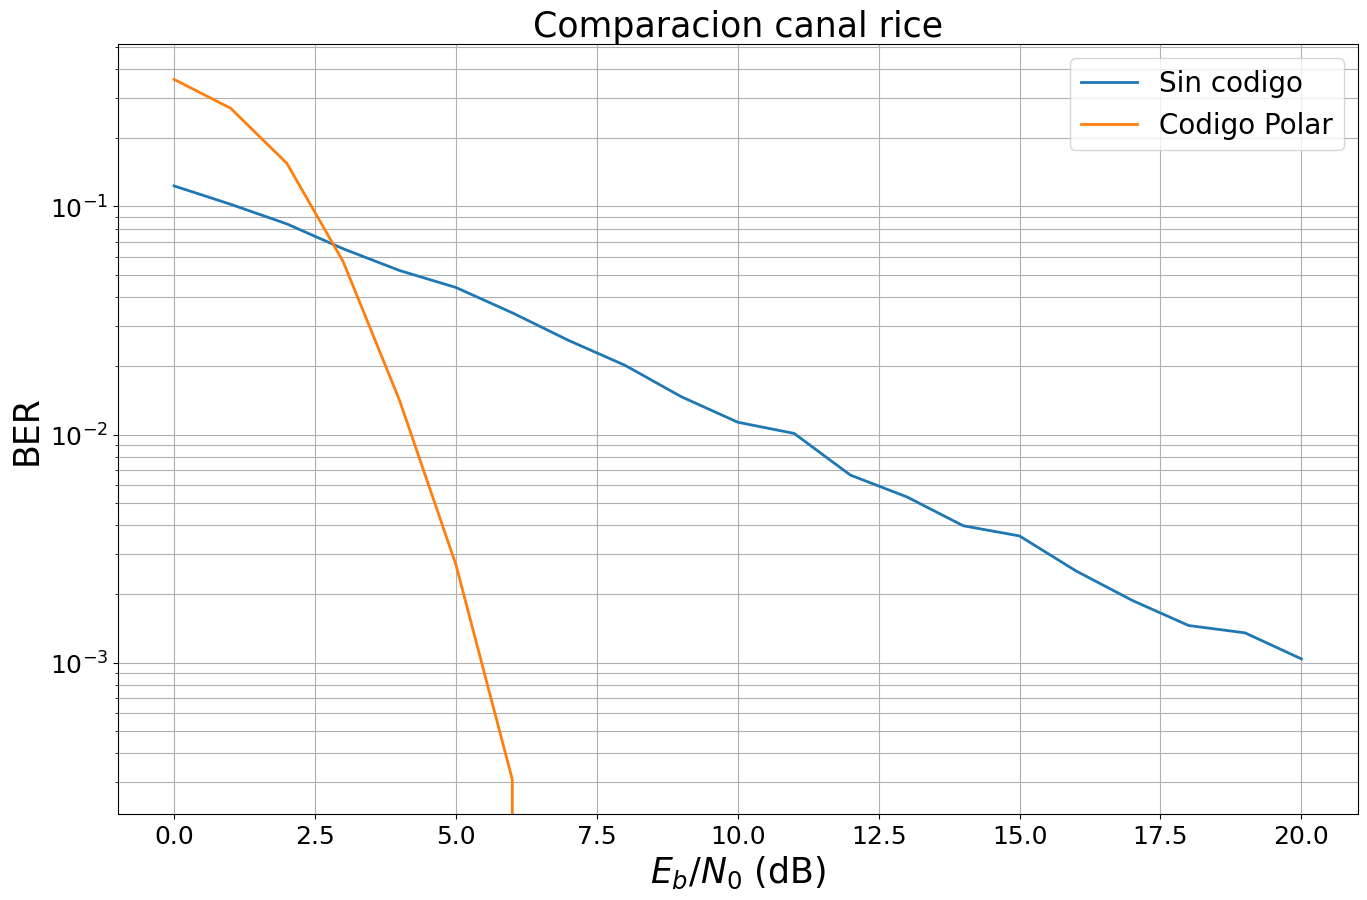

In [17]:
# Simulación y ploteo de BER con codigo polar

# En caso de error de memoria, ejecute tf.keras.backend.clear_session()
ber_plots.simulate(codigo_polar,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=250,
                   legend="Codigo Polar",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

In [18]:
# Define el sistema de telecomunicaciones a simular, con código LDPC

class CodigoLDPC(sionna.phy.Block):
    def __init__(self, canal, ecualizador, N, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.N = N
        self.K = K
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
        # Inicializa los bloques necesarios
        self.ldpc_codif = sionna.phy.fec.ldpc.encoding.LDPC5GEncoder(self.K, self.N, self.bitsxsimb)
        self.ldpc_decodif = sionna.phy.fec.ldpc.decoding.LDPC5GDecoder(self.ldpc_codif)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = datos([batch_size, self.K])
        bits_codif = self.ldpc_codif(b)
        bits_int = interleaver(bits_codif)
        x = mapeador(bits_int)

        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        else:
            raise Exception("Debe seleccionar un canal valido")

        # Bloques de recepcion
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("Debe seleccionar un ecualizador valido")
        
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)
        b_hat = self.ldpc_decodif(llr)

        return b, b_hat

In [19]:
# Se crea la instancia de clase Codigo LDPC con los parametros generales

codigo_ldpc = CodigoLDPC(canal, ecualizador, N, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.1836e-01 | 9.7250e-01 |        5590 |       25600 |          389 |         400 |         2.1 |reached target block errors
      1.0 | 1.6887e-01 | 8.2250e-01 |        4323 |       25600 |          329 |         400 |         1.1 |reached target block errors
      2.0 | 1.0408e-01 | 5.4375e-01 |        5329 |       51200 |          435 |         800 |         2.3 |reached target block errors
      3.0 | 4.2435e-02 | 2.4417e-01 |        3259 |       76800 |          293 |        1200 |         3.4 |reached target block errors
      4.0 | 1.7059e-02 | 9.3929e-02 |        3057 |      179200 |          263 |        2800 |         8.2 |reached target block errors
      5.0 | 4.1453e-03 | 2.2800e-02 |        2653 |      640000 |

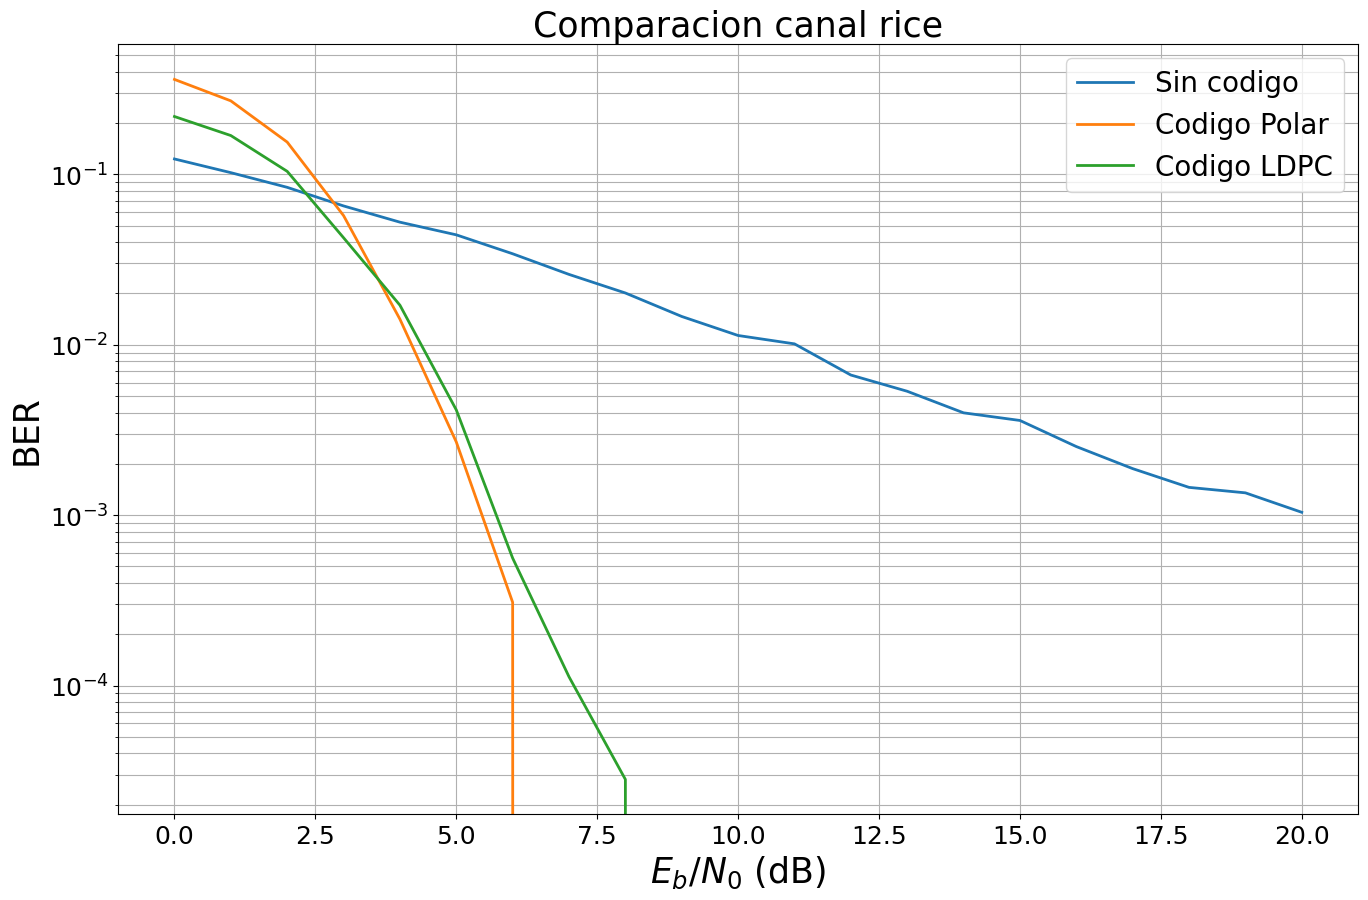

In [20]:
# Simulación y ploteo de BER con codigo LDPC

# En caso de error de memoria, ejecute tf.keras.backend.clear_session()
ber_plots.simulate(codigo_ldpc,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=250,
                   legend="Codigo LDPC",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);